<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/Modeling/Copy_of_Prod_Sklearn_withlogger_DH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of this notebook is to determine which model returns the highest R2 by feature reduction techniques and hp tuning

In [1]:
!git clone https://github.com/harperd17/energy_volatility_prediction.git

Cloning into 'energy_volatility_prediction'...
remote: Enumerating objects: 555, done.
remote: Counting objects: 100% (555/555), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 555 (delta 335), reused 16 (delta 9), pack-reused 0
Receiving objects: 100% (555/555), 6.79 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (335/335), done.


In [2]:
!pip install neptune-client --quiet
import neptune.new as neptune
!pip install optuna
import optuna

import pandas as pd
import numpy as np
import sys
sys.path.append("energy_volatility_prediction/helpers/")

from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt

import warnings
from energy_volatility_prediction.helpers.fengine import Fengine
from energy_volatility_prediction.helpers.model_functions import *
from sklearnlogger import SklearnLogger


from google.colab import drive

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,RidgeCV,LassoCV,
                                  ElasticNet,ElasticNetCV,Lars,LarsCV,BayesianRidge,
                                  ARDRegression, PassiveAggressiveRegressor, 
                                  SGDRegressor,TheilSenRegressor,
                                  HuberRegressor,LassoLarsCV,LassoLarsIC)#QuantileRegressor,TweedieRegressor,)

from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor,HistGradientBoostingRegressor,
                              GradientBoostingRegressor,RandomForestRegressor,
                              StackingRegressor,VotingRegressor,
                              )

from sklearn.svm import (LinearSVR,NuSVR,SVR)

from sklearn.model_selection import GridSearchCV, cross_val_score

from datetime import datetime
import json
from sklearn.linear_model import LinearRegression,Lasso
import xgboost as xgb
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

     |████████████████████████████████| 276 kB 5.1 MB/s 
     |████████████████████████████████| 829 kB 32.9 MB/s 
     |████████████████████████████████| 52 kB 818 kB/s 
     |████████████████████████████████| 180 kB 54.9 MB/s 
     |████████████████████████████████| 131 kB 51.8 MB/s 
     |████████████████████████████████| 8.4 MB 14.0 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 138 kB 47.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 127 kB 59.0 MB/s 
     |████████████████████████████████| 130 kB 25.9 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 308 kB

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
drive.mount('./drive/')

%cd drive/Shareddrives/Data606_Energy

Mounted at ./drive/
/content/drive/Shareddrives/Data606_Energy


## This will set the prefix of your log file name

In [4]:
name = "David"
#Not grid "adamgoldsteindatascience/energyprice-volatility-grid"

neptune_project_name = "adamgoldsteindatascience/energyprice-volatility"

#Overall Reproduceability
random_state = 0

In [5]:
param_lookup = {
    'Lasso':{'alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10)},
    'Ridge':{'alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10)},
    'ExtraTreesRegressor':{'ccp_alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10),
                           'max_depth':optuna.distributions.LogUniformDistribution(10,200),
                           'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                           'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,128),
                           'min_samples_split':optuna.distributions.LogUniformDistribution(1,128),
                           'n_estimators':optuna.distributions.LogUniformDistribution(20,300)
                           },
    'RandomForestRegressor':{'ccp_alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10),
                           'max_depth':optuna.distributions.LogUniformDistribution(10,200),
                           'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                           'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,128),
                           'min_samples_split':optuna.distributions.LogUniformDistribution(1,128),
                           'n_estimators':optuna.distributions.LogUniformDistribution(20,300)
                           },
    'HistGradientBoostingRegressor':{'learning_rate':optuna.distributions.LogUniformDistribution(0.00001,0.5),
                                     'max_depth':optuna.distributions.LogUniformDistribution(10,75),
                                      'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                                      'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,64)},
    'GradientBoostingRegressor':{'n_estimators':optuna.distributions.DiscreteUniformDistribution(10,5000,1),
                                 'subsample':optuna.distributions.LogUniformDistribution(0.1,1.1),
                                 'max_features':optuna.distributions.DiscreteUniformDistribution(1,50,1),
                                 'learning_rate':optuna.distributions.LogUniformDistribution(0.000001,1),
                                 'max_depth':optuna.distributions.DiscreteUniformDistribution(1,20,1)},
        # 'alpha':optuna.distributions.LogUniformDistribution(0.0000001,1000000),
        #                          'ccp_alpha':optuna.distributions.LogUniformDistribution(0.0000001,1000000),
        #                             'learning_rate':optuna.distributions.LogUniformDistribution(0.00001,0.5),
        #                              'max_depth':optuna.distributions.LogUniformDistribution(10,75),
        #                               'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
        #                               'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,64),
        #                               'min_samples_split':optuna.distributions.LogUniformDistribution(1,64)},
      'XGBRegressor':{'objective':optuna.distributions.CategoricalDistribution('reg:linear'),
                      'colsample_bytree':optuna.distributions.LogUniformDistribution(0.0000001,1),
                      'eta':optuna.distributions.LogUniformDistribution(0.0001,0.5),
                      #'max_depth':optuna.distributions.LogUniformDistribution(5,200),
                      #'alpha':optuna.distributions.LogUniformDistribution(0.0001,1000),
                      'n_estimators':optuna.distributions.LogUniformDistribution(5,100),
                      'subsample':optuna.distributions.LogUniformDistribution(0.00001,1)}

}

In [6]:
def objective_gradient_boosting_regressor(trial):   
  n_estimators = int(trial.suggest_int('n_estimators',10,5000))
  subsample = trial.suggest_loguniform('subsample',0.1,1)
  max_features = int(trial.suggest_int('max_features',1,50))
  learning_rate = trial.suggest_loguniform('learning_rate',0.000001,1)
  max_depth = int(trial.suggest_int('max_depth',1,20))
  # print(n_estimators)
  # print(subsample)
  # print(max_features)
  # print(learning_rate)
  # print(max_depth)

  model = GradientBoostingRegressor(n_estimators=int(n_estimators),subsample=subsample,max_features=int(max_features),learning_rate=learning_rate,max_depth=int(max_depth))
  # print(model)
  # model.fit(X_train,y_train)
  scores = cross_val_score(model,X_train,y_train,cv=5)
  # print(scores)
  return scores.mean()


In [7]:
def objective_hist_gradient_boosting_regressor(trial):   
  max_iter = trial.suggest_int('max_iter',1,500)
  learning_rate = trial.suggest_loguniform('learning_rate',0.000001,1)
  max_depth = trial.suggest_int('max_depth',1,20)
  # print(n_estimators)
  # print(subsample)
  # print(max_features)
  # print(learning_rate)
  # print(max_depth)

  model = HistGradientBoostingRegressor(max_iter=max_iter,learning_rate=learning_rate,max_depth=int(max_depth))
  # print(model)
  # model.fit(X_train,y_train)
  scores = cross_val_score(model,X_train,y_train,cv=5)
  # print(scores)
  return scores.mean()

In [8]:
def objective_lasso(trial):
  alpha = trial.suggest_float('alpha',1e-10, 1e10)
  model = Lasso(alpha=alpha)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [9]:
def objective_ridge(trial):
  alpha = trial.suggest_float('alpha',1e-10, 1e10)
  model = Ridge(alpha=alpha)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [10]:
def objective_extra_trees_regressor(trial):
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_features = trial.suggest_int('max_features',1,30)
  max_samples = trial.suggest_int('max_samples',2,20)

  model = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features,max_samples=max_samples)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [11]:
def objective_random_forest_regressor(trial):
  max_samples = trial.suggest_float('max_samples',0.0001,0.9999)
  max_features = trial.suggest_int('max_features',1,30)
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_depth = trial.suggest_int('max_depth',2,20)

  model = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,max_samples=max_samples)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [12]:
def get_xgboost_most_used(mod,count_thresh):
  print("inside get_most_used")
  print(pd.Series([f[1] for f in mod.get_booster().get_fscore().items()]))
  thresh = int(pd.Series([f[1] for f in mod.get_booster().get_fscore().items()]).quantile(count_thresh))
  print("Threshold is {}".format(thresh))
  most_relevant_features= list( dict((k, v) for k, v in mod.get_booster().get_fscore().items() if v >= thresh).keys())
  print(mod.get_booster().get_fscore().items())
  most_relevant_features = [int(f.replace('f','')) for f in most_relevant_features]
  print("Most Relevant Features {}".format(most_relevant_features))
  # train_x=df_model[np.array(df_model.columns)[most_relevant_features]]
  # del train_x['target_COV']
  # train_y=df_model['target_COV']
  # X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)
  X_train_pd = pd.DataFrame(X_train,columns=X.columns)
  X_test_pd = pd.DataFrame(X_test,columns=X.columns)
  X_train_pd = X_train_pd[np.array(X_train_pd.columns)[most_relevant_features]]
  X_test_pd = X_test_pd[np.array(X_test_pd.columns)[most_relevant_features]]
  return X_train_pd, X_test_pd

In [98]:
def objective_xgboost(trial):
  # reg_lambda = trial.suggest_float('reg_lambda',0.00001,1)
  # reg_alpha = trial.suggest_float('reg_alpha',0.0001,10)
  # colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1.0)
  # subsample = trial.suggest_float('subsample',0.3,1.0)
  # learning_rate = trial.suggest_float('learning_rate',0.0001,1)
  # n_estimators = trial.suggest_int('n_estimators',10,5000)
  # max_depth = trial.suggest_int('max_depth',1,25)
  # min_child_weight = trial.suggest_int('min_child_weight',1,300)

  # model = xgb.XGBRegressor(reg_lambda=reg_lambda, reg_alpha=reg_alpha,
  #                          colsample_bytree=colsample_bytree,subsample=subsample,
  #                          learning_rate=learning_rate,n_estimators=n_estimators,
  #                          max_depth=max_depth,min_child_weight=min_child_weight)
  # model = model.fit(X_train,y_train)
  # pred = model.predict(X_train)
  # r2 = r2_score(y_train,pred)
  # scores = cross_val_score(model,X_train,y_train)
  # print("R2 {}".format(r2))
  # print("CV {}".format(scores.mean()))
  # r2_test = r2_score(y_test,model.predict(X_test))
  # #print(r2_test)
  # #return r2_test - max(0,(r2-r2_test))
  # return scores.mean() - 3*max(0,(r2-scores.mean()))
  # reg_lambda = trial.suggest_float('reg_lambda',0.00001,1)
  # reg_alpha = trial.suggest_float('reg_alpha',0.0001,10)
  # colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1.0)
  # subsample = trial.suggest_float('subsample',0.3,1.0)
  learning_rate = trial.suggest_float('learning_rate',0.0001,1)
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_depth = trial.suggest_int('max_depth',1,25)
  # min_child_weight = trial.suggest_int('min_child_weight',1,300)
  print("Value suggestions done")
  # model = xgb.XGBRegressor(reg_lambda=reg_lambda, reg_alpha=reg_alpha,
  #                          colsample_bytree=colsample_bytree,subsample=subsample,
  #                          learning_rate=learning_rate,n_estimators=n_estimators,
  #                          max_depth=max_depth,min_child_weight=min_child_weight)
  random_state = 0
  train_size = 0.8
  num_folds = 5
  eval_scores = []
  train_scores = []
  print('learning_rate {}'.format(learning_rate))
  print('n_estimators {}'.format(n_estimators))
  print('max_depth {}'.format(max_depth))
  # model = model = xgb.XGBRegressor(learning_rate=learning_rate,n_estimators=n_estimators,
  #                          max_depth=max_depth)
  # model.fit(X_train,y_train)
  # X_train_new,X_test_new = get_xgboost_most_used(model,0.9)
  X_train_new, y_train_new = X_train, y_train
  state_col = pd.Series(X.columns)[pd.Series(X.columns)=='State'].index[0]
  # print(state_col)
  # print(X_train_new.shape)
  for fold in range(num_folds):
    cv_X_train,cv_X_test,cv_y_train,cv_y_test = tts(X_train_new,y_train,random_state=random_state,train_size=train_size, stratify=X_train_new[:,state_col])
    model = xgb.XGBRegressor(learning_rate=learning_rate,n_estimators=n_estimators,
                           max_depth=max_depth)
    model.fit(cv_X_train,cv_y_train)#,early_stopping_rounds=5, eval_set=[(cv_X_test,cv_y_test)],verbose=False)
    eval_scores.append(r2_score(cv_y_test,model.predict(cv_X_test)))
    train_scores.append(r2_score(cv_y_train,model.predict(cv_X_train)))

  # model = xgb.XGBRegressor(learning_rate=learning_rate,n_estimators=n_estimators,
  #                          max_depth=max_depth)
  # model.fit(X_train,y_train,verbose=False)#early_stopping_rounds=5,eval_set=[(X_test, y_test)], verbose=False)
  # return r2_score(y_test,model.predict(X_test)) - 3*max(0,(r2_score(y_train,model.predict(X_train))-r2_score(y_test,model.predict(X_test))))
  print('Train Scores: {}'.format(np.mean(train_scores)))
  print('Eval Scores: {}'.format(np.mean(eval_scores)))
  return np.mean(eval_scores) - 3*max(0,np.mean(train_scores)-np.mean(eval_scores))

In [99]:
model_functions = {'GradientBoostingRegressor':objective_gradient_boosting_regressor,
                   'HistGradientBoostingRegressor':objective_hist_gradient_boosting_regressor,
                   'Lasso':objective_lasso,
                   'Ridge':objective_ridge,
                   'ExtraTreesRegressor':objective_extra_trees_regressor,
                   'RandomForestRegressor':objective_random_forest_regressor,
                   'XGBRegressor':objective_xgboost

                   }

In [90]:
def get_ft(model,label):

    try:

        if label == "Linear":

            return model.coef_

        if label == "Ensemble":

            return model.feature_importances_

    except:

        None
# def objective_tree(trial,X_train,y_train,param,model):  
#   n_estimators = trial.suggest_loguniform(10,5000)
#   subsample=trial.suggest_loguniform(0.1,1.1)
#   max_features = trial.suggest_loguniform(1,50)
#   learning_rate = trial.suggest_loguniform(0.000001,1)
#   max_depth = trial.suggest_loguniform(1,20)

#   model = model(n_estimators=n_estimators,subsample=subsample,max_features=max_features,learning_rate=learning_rate,max_depth=max_depth)
#   scores = cross_val_score(model,X_train,y_train,cv=5)

#   return scores.mean()


def fit_model_predict(model,label,X_train,X_test,y_train,y_test):
        #param_distributions = param_lookup[type(model()).__name__]
        
        # func = lambda trial: objective(trial, X_train, y_train, param_distributions, model)
        optuna_search = optuna.create_study(direction='maximize')
        optuna_search.optimize(model_functions[type(model()).__name__],n_trials=1000)
        # optuna_search = optuna.integration.OptunaSearchCV(model(), param_distributions,cv=5, n_trials=5)
        # optuna_search.fit(X_train, y_train)
        print("Optuna Results")
        #print(type(optuna_search))
        print(optuna_search.best_params)
        print(optuna_search.best_value)
        model = model(**optuna_search.best_params)
        # for param in optuna_search.best_params_:
        #   setattr(model,param,optuna_search.best_params_[param])
        fitted_model = model.fit(X_train,y_train)
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)

        #Calculate r2
        evs_train = round(explained_variance_score(y_train,y_preds_train),2)
        evs_test = round(explained_variance_score(y_test,y_preds_test),2)

        #Calculate r2
        r2_train = round(r2_score(y_train,y_preds_train),2)
        r2_test  = round(r2_score(y_test,y_preds_test),2)

        adjusted_r2_train = calc_adjusted_r2(X_train,r2_train)
        adjusted_r2_test = calc_adjusted_r2(X_test,r2_test)

        mse_value_train = mse(y_preds_train,y_train)
        mse_value_test = mse(y_preds_test,y_test)


        coeff = get_ft(model,label)
        
        return {
                "Parameters":model.get_params(),
                "Explained_Variance_Score_test":evs_test,
                "R2_test":r2_test,
                "Adj_R2_test":adjusted_r2_test,
                "MSE_test":mse_value_test,
                "y_preds_test":y_preds_test,

                "Explained_Variance_Score_train":evs_train,
                "R2_train":r2_train,
                "Adj_R2_train":adjusted_r2_train,
                "MSE_train":mse_value_train,
                "y_preds_train":y_preds_train,

                "Coef_train":coeff,
                }, optuna_search.best_params


def fit_grid_cv(model,X_train,y_train,score,cv=3) -> pd.DataFrame:

        grid_cv = GridSearchCV(model[0],scoring=score,cv=cv,param_grid=model[1])
        fitted_model = grid_cv.fit(X_train,y_train)

        return fitted_model.cv_results_


def calc_adjusted_r2(X_test,r2):
        #Adjusted R Squared = 1 – [((1 – R2) * (n – 1)) / (n – k – 1)]
        n = X_test.shape[0]
        k = X_test.shape[1]
        first_part = ((1-r2)*(n-1))
        second_part = (n-k-1)
        adjusted_r2 = 1 - (first_part / second_part)

        return adjusted_r2


def format_gridcv_logger(df,result_df_len=5):

    df = df.explode("mean_test_score")

    df_history = df.set_index(["cust_Date","cust_Model","mean_test_score"]).reset_index().sort_values("mean_test_score",ascending=False)

    df_trim = explode_grid_csv(df.head(result_df_len),["param_n_estimators","param_max_depth","param_max_leaf_nodes"],metric="mean_test_score")

    return df_history,df_trim

def explode_grid_csv(df,cols,not_explode_cols_startwith="cust_",metric="mean_test_score"):

    for col in cols:

        df = df.explode(col)

        df[col] = df[col].astype("float")

    return df[[col for col in df.columns if col == metric or col in cols 
               or col.startswith(not_explode_cols_startwith 
                )]]





#Select Models

In [18]:
#One offs
linear_models = [LinearRegression(),Lasso()]

xgb_models = [xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)]



model_pipeline = [("XGB",xgb_models)] + [("Linear",linear_models)]
model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor]),('Boosting',[HistGradientBoostingRegressor,GradientBoostingRegressor])]


# #Sets or Grid CV - Add one more for loop above training loop
# model_pipeline = [get_linear_models(),get_ensemble_models()]

In [19]:
df = pd.read_csv("data/merge_ready/merged_data_2001-2020_new_data.csv")

In [83]:
func_lists = []
#himanshu's current pipeline
func_lists.append([#['min_max_scale',["Agg_total_plant_MWh", "Agg_total_plant_count"]],
                    ['scale_month_columns',None],
                    #['categorize','State'],
                    ['encode_state_by_COV',None],
                    ['drop_columns',['Year','year.1']],
                    ['treat_bad_values',None],
                    ("outlier_thresh",3),("col_not_startswith","R_"),
                    ("col_not_startswith","Agg_R"),
                    ("col_not_endswith","_y")])
# func_lists.append([
#                   ['average_weather_columns','Temp Standard Deviations ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted Temp Standard Deviation Summer Months'],
#                   ['average_weather_columns','Temp Averages ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted Temp Average Summer Months'],
#                   ['average_weather_columns','Temp Standard Deviations ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted Temp Standard Deviation Winter Months'],
#                   ['average_weather_columns','Temp Averages ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted Temp Average Winter Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted PDSI Standard Deviation Summer Months'],
#                   ['average_weather_columns','PDSI Averages ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted PDSI Average Summer Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted PDSI Standard Deviation Winter Months'],
#                   ['average_weather_columns','PDSI Averages ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted PDSI Average Winter Months'],
#                   ['average_weather_columns','Standardized Drought ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted Summer Month Drought'],
#                   ['average_weather_columns','Standardized Drought ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted Winter Month Drought'],
#                   ['average_weather_columns','Standardized Temp ',(4,5,6,7,8,9),[0,0,0,0,1,0],'Weighted Summer Month Temp'],
#                   ['average_weather_columns','Standardized Temp ',(10,11,12, 1,2,3),[0,0,0,0,1,0],'Weighted Winter Month Temp'],
#                   ("outlier_thresh",2.5),
#                   ("col_not_startswith","R_"),
#                   ("col_not_endswith","_y"),
#                   ("add_entities",None),
#                   ("add_carbon_policy",None),
#                   ('one_hot_encode','State'),
#                   ("col_not_endswith","Year"),
#                   ("col_not_endswith","statepop"),
#                   ("col_not_endswith","count"),
#                   ("col_not_endswith","BZ=F"),
#                   ("standardize_numeric_by_nation",'Agg_total_plant_MWh_x'),
#                   ("standardize_numeric_by_nation",'x'),
#                   ("standardize_numeric_by_nation",'y'),
#                   ("standardize_numeric_by_nation",'Population Density'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly NG=F'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly CL=F'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly HO=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement NG=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement CL=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement HO=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume NG=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume CL=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume HO=F')
#                   ])

In [84]:
func_lists.append([
                  ['col_not_have_and_has','Temp Average','7'],
                  ['col_not_have_and_has','Temp Standard Deviation','13'],
                  ['col_not_have_and_has','Standardized Temp','13'],
                  ['col_not_have_and_has','PDSI Average','8'],
                  ['col_not_have_and_has','PDSI Standard Deviation','13'],
                  ['col_not_have_and_has','Standardized Drought','13'],
                  ("outlier_thresh",3.0),
                  ['encode_state_by_COV',None],
                  ("col_not_startswith","R_"),
                  ("col_not_endswith","_y"),
                  ("add_entities",None),
                  ("add_carbon_policy",None),
                  ("col_not_endswith","Year"),
                  ("col_not_endswith","statepop"),
                  ("col_not_endswith","count"),
                  ("col_not_endswith","BZ=F"),
                  ("standardize_numeric_by_nation",'Agg_total_plant_MWh_x'),
                  ("standardize_numeric_by_nation",'x'),
                  ("standardize_numeric_by_nation",'y'),
                  ("standardize_numeric_by_nation",'Population Density'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly NG=F'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly CL=F'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly HO=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement NG=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement CL=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement HO=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume NG=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume CL=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume HO=F'),
                  #['categorize','State'],
                  #('one_hot_encode','State')
                  #['drop_columns','State']
                  ])

In [139]:

# func_lists.append([
#                   ['average_weather_columns','Temp Standard Deviations ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Standard Deviation Summer Months'],
#                   ['average_weather_columns','Temp Averages ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Average Summer Months'],
#                   ['average_weather_columns','Temp Standard Deviations ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Standard Deviation Winter Months'],
#                   ['average_weather_columns','Temp Averages ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Average Winter Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Summer Months'],
#                   ['average_weather_columns','PDSI Averages ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Average Summer Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Winter Months'],
#                   ['average_weather_columns','PDSI Averages ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Average Winter Months'],
#                   ['average_weather_columns','Standardized Drought ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Drought'],
#                   ['average_weather_columns','Standardized Drought ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Drought'],
#                   ['average_weather_columns','Standardized Temp ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Temp'],
#                   ['average_weather_columns','Standardized Temp ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Temp'],
#                   ("outlier_thresh",2.5),
#                   ("col_not_startswith","R_"),
#                   ("col_not_endswith","_y"),
#                   ("add_entities",None),
#                   ("add_carbon_policy",None),
#                   ("col_not_endswith","Year"),
#                   ("col_not_endswith","statepop"),
#                   ("col_not_endswith","count"),
#                   ("col_not_endswith","BZ=F"),
#                   ("standardize_numeric_by_nation",'COV'),
#                   ("standardize_numeric_by_nation",'target_COV'), 
#                   ("standardize_numeric_by_nation",'Agg_total_plant_MWh_x'),
#                   ("standardize_numeric_by_nation",'x'),
#                   ("standardize_numeric_by_nation",'y'),
#                   ("standardize_numeric_by_nation",'Population Density'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly NG=F'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly CL=F'),
#                   ("standardize_numeric_by_nation",'Mean Volume Weekly HO=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement NG=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement CL=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Movement HO=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume NG=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume CL=F'),
#                   ("standardize_numeric_by_nation",'Months Above Average Price Volume HO=F'),
#                   ('one_hot_encode','State'),
#                   ])

In [133]:
# func_lists.append([
#                   ['average_weather_columns','Temp Standard Deviations ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Standard Deviation Summer Months'],
#                   ['average_weather_columns','Temp Averages ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Average Summer Months'],
#                   ['average_weather_columns','Temp Standard Deviations ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Standard Deviation Winter Months'],
#                   ['average_weather_columns','Temp Averages ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Average Winter Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Summer Months'],
#                   ['average_weather_columns','PDSI Averages ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Average Summer Months'],
#                   ['average_weather_columns','PDSI Standard Deviations ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Winter Months'],
#                   ['average_weather_columns','PDSI Averages ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Average Winter Months'],
#                   ['average_weather_columns','Standardized Drought ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Drought'],
#                   ['average_weather_columns','Standardized Drought ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Drought'],
#                   ['average_weather_columns','Standardized Temp ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Temp'],
#                   ['average_weather_columns','Standardized Temp ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Temp'],
#                   ("outlier_thresh",2.5),
#                   ("col_not_startswith","R_"),
#                   ("col_not_endswith","_y"),
#                   ("add_entities",None),
#                   ("add_carbon_policy",None),
#                   ("col_not_endswith","Year"),
#                   ("col_not_endswith","statepop"),
#                   ("col_not_endswith","count"),
#                   ("col_not_endswith","BZ=F"),
#                   ("standardize_numeric_by_state",'COV'), 
#                   ("standardize_numeric_by_state",'target_COV'),
#                   ("standardize_numeric_by_state",'Agg_total_plant_MWh_x'),
#                   ("standardize_numeric_by_state",'x'),
#                   ("standardize_numeric_by_state",'y'),
#                   ("standardize_numeric_by_state",'Population Density'),
#                   ("standardize_numeric_by_state",'Mean Volume Weekly NG=F'),
#                   ("standardize_numeric_by_state",'Mean Volume Weekly CL=F'),
#                   ("standardize_numeric_by_state",'Mean Volume Weekly HO=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Movement NG=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Movement CL=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Movement HO=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Volume NG=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Volume CL=F'),
#                   ("standardize_numeric_by_state",'Months Above Average Price Volume HO=F'),
#                    ('one_hot_encode','State'),
#                    ['treat_bad_values',None]
#                   ])

In [20]:
# func_lists.append([
#                   # ['average_weather_columns','Temp Standard Deviations ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Standard Deviation Summer Months'],
#                   # ['average_weather_columns','Temp Averages ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Average Summer Months'],
#                   # ['average_weather_columns','Temp Standard Deviations ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Standard Deviation Winter Months'],
#                   # ['average_weather_columns','Temp Averages ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Average Winter Months'],
#                   # ['average_weather_columns','PDSI Standard Deviations ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Summer Months'],
#                   # ['average_weather_columns','PDSI Averages ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Average Summer Months'],
#                   # ['average_weather_columns','PDSI Standard Deviations ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Winter Months'],
#                   # ['average_weather_columns','PDSI Averages ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Average Winter Months'],
#                   # ['average_weather_columns','Standardized Drought ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Drought'],
#                   # ['average_weather_columns','Standardized Drought ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Drought'],
#                   # ['average_weather_columns','Standardized Temp ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Temp'],
#                   # ['average_weather_columns','Standardized Temp ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Temp'],
#                   ("outlier_thresh",3),
#                   #("power",'target_COV',0.5),
#                   ("col_not_startswith","R_"),
#                   ("col_not_endswith","_y"),
#                   ("add_entities",None),
#                   ("add_carbon_policy",None),
#                   ('one_hot_encode','State'),
#                   ("col_not_endswith","Year"),
#                   ("col_not_endswith","statepop"),
#                   ("col_not_endswith","count"),
#                   ("col_not_endswith","BZ=F"),
#                   # ("standardize_numeric_by_state",'target_COV'),
#                   # ("standardize_numeric_by_state",'Agg_total_plant_MWh_x'),
#                   # ("standardize_numeric_by_state",'x'),
#                   # ("standardize_numeric_by_state",'y'),
#                   # ("standardize_numeric_by_state",'Population Density'),
#                   # ("standardize_numeric_by_state",'Mean Volume Weekly NG=F'),
#                   # ("standardize_numeric_by_state",'Mean Volume Weekly CL=F'),
#                   # ("standardize_numeric_by_state",'Mean Volume Weekly HO=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Movement NG=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Movement CL=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Movement HO=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Volume NG=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Volume CL=F'),
#                   # ("standardize_numeric_by_state",'Months Above Average Price Volume HO=F'),
                  
#                    ("min_max_scale",'COV'),
#                    ("min_max_scale",'target_COV'),
#                   ("min_max_scale",'Agg_total_plant_MWh_x'),
#                   ("min_max_scale",'x'),
#                   ("min_max_scale",'y'),
#                   ("min_max_scale",'Population Density'),
#                   ("min_max_scale",'Mean Volume Weekly NG=F'),
#                   ("min_max_scale",'Mean Volume Weekly CL=F'),
#                   ("min_max_scale",'Mean Volume Weekly HO=F'),
#                   ("min_max_scale",'Months Above Average Price Movement NG=F'),
#                   ("min_max_scale",'Months Above Average Price Movement CL=F'),
#                   ("min_max_scale",'Months Above Average Price Movement HO=F'),
#                   ("min_max_scale",'Months Above Average Price Volume NG=F'),
#                   ("min_max_scale",'Months Above Average Price Volume CL=F'),
#                   ("min_max_scale",'Months Above Average Price Volume HO=F')
#                   ])

In [22]:
# from sklearn.preprocessing import MinMaxScaler

In [23]:
# df_model['COV'] = MinMaxScaler().fit_transform(df_model[['COV']])

In [24]:
# df_model = feature_engineering_pipeline(df,Fengine,func_lists[0])

In [25]:
#df_model = df_model.dropna()
# df_model = sm.add_constant(df_model)

In [26]:
# X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
#                                                   target="target_COV_state")

# Feature Engineering Pipeline

In [ ]:
# #Function lists

# func_lists = []

# func_lists.append([("outlier_thresh",3),("col_not_startswith","R_"),
#              ("col_not_endswith","_y")])

# func_lists.append([("outlier_thresh",3),("col_not_startswith","Agg_R"),
#              ("col_not_endswith","_x")])

In [ ]:
# func_lists = []

# func_lists.append([("outlier_thresh",2.5),
#                    ("col_not_startswith","R_"),
#                    ("col_not_endswith","_y"),
#                    ("add_entities",None),
#                    ("add_carbon_policy",None),
#                    ("standardize_numeric_by_nation",None)])

In [27]:
# def build_regression_model(y,x):
#   ## first, build a model with all the initial columns
#   initial_model = sm.OLS(y.astype(float), x.astype(float))
#   res = initial_model.fit()
#   # only keep the variables with a p-value less than or equal to 0.1
#   good_variables = list(res.pvalues[res.pvalues<0.1].index)
#   # make sure the intercept is still part of the model
#   if 'const' not in good_variables:
#     good_variables.append('const')
#   # now iterate through until the only variables left only have a p-value less than 0.05
#   high_p_values = True
#   while high_p_values:
#     mod = sm.OLS(y.astype(float), x[good_variables].astype(float))
#     res = mod.fit()
#     bad_variables = list(res.pvalues[res.pvalues>0.05].index)
#     # if constant is in here, it shouldn't count against the model if it has a "bad" p-value
#     if 'const' in bad_variables:
#       bad_variables.remove('const')
#     if len(bad_variables) == 0:
#       high_p_values = False
#     else:
#       good_variables = list(res.pvalues[res.pvalues<=0.05].index)
#       # make sure the intercept is still part of the model
#       if 'const' not in good_variables:
#         good_variables.append('const')
#   param_list = list(res.params.index)
#   param_list.remove('const')
#   return param_list, res, mod

In [28]:
# import statsmodels.api as sm
# df_model = feature_engineering_pipeline(df,Fengine,func_lists[0])
# #df_model = df_model.dropna()
# X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
#                                                   target="target_COV")
# X_train = pd.DataFrame(X_train,columns=X.columns)
# X_train_constant = sm.add_constant(X_train)
# y_train = pd.DataFrame(y_train)#,name='target_COV')
# X_test = pd.DataFrame(X_test,columns=X.columns)
# X_test_constant = sm.add_constant(X_test)
# y_test = pd.DataFrame(y_test)#,name='target_COV')



In [29]:
# best_params, res,mod = build_regression_model(y_train,X_train_constant)

In [30]:
# res.summary()

In [31]:
# r2_score(y_test,res.predict(X_test_constant[best_params+['const']]))

In [32]:
# def find_most_correlated(df, target_var,n):
#   corrs = df.corr().abs()[target_var].sort_values(ascending=False)
#   return df[list(corrs[:n].index)]

# Executed Pipeline with Logger

In [107]:
dfs = [pd.read_csv("data/merge_ready/merged_data_2001-2020.csv"), pd.read_csv("data/merge_ready/merged_data_2001-2020_new_data.csv")]
#df = pd.read_csv("data/merge_ready/merged_data_2001-2020.csv")

In [108]:
import xgboost as xgb
# model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor])
# model_pipeline = [('Boosting',[HistGradientBoostingRegressor])]
model_pipeline = [('XGB',[xgb.XGBRegressor])]
# model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor]), 
#                   ('Boosting',[GradientBoostingRegressor,HistGradientBoostingRegressor]),('XGB',[xgb.XGBRegressor])]

In [109]:
model_pipeline

[('XGB', [xgboost.sklearn.XGBRegressor])]

In [110]:
optuna.logging.set_verbosity(optuna.logging.WARNING)#WARNING

Streaming output truncated to the last 5000 lines.
max_depth 5
[02:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Scores: 0.9977698528196923
Eval Scores: 0.6930285478821223
Value suggestions done
learning_rate 0.6825857702379454
n_estimators 437
max_depth 2
[02:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:13] WARNING: /work

KeyboardInterrupt: ignored

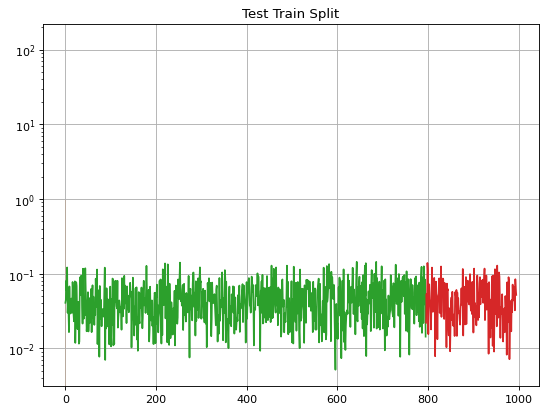

In [111]:


df_models = []
all_params = []
plt.figure(figsize=(8, 6), dpi=80)


# Iterate over feature engineering
for index, func_list in enumerate(func_lists):

    print_header(f"Feature Engineering Pipeline {index}")
    df = dfs[index].copy()
    df_model = feature_engineering_pipeline(df,Fengine,func_list)
    #df_model = df_model.dropna()
    #df_model = find_most_correlated(df_model,'target_COV',10)

    X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
                                                  target="target_COV",stratify=df_model['State'])
    # #------------------------------------------------------------------------------------
    # # find the most important features from OLS
    # X_train = pd.DataFrame(X_train,columns=X.columns)
    # X_train_constant = sm.add_constant(X_train)
    # y_train = pd.DataFrame(y_train)#,name='target_COV')
    # X_test = pd.DataFrame(X_test,columns=X.columns)
    # X_test_constant = sm.add_constant(X_test)
    # y_test = pd.DataFrame(y_test)#,name='target_COV')

    # best_params = build_regression_model(y_train,X_train_constant)
    # df_model = df_model[best_params+['target_COV']]
    # X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
    #                                               target="target_COV")
    # #------------------------------------------------------------------------------------
    df_models.append(df_model.copy())
    plot_test_train(X_train,X_test,y_train,y_test)
    param_list = []

#Modeling
    for label,models in model_pipeline:

        print_header("Models tested")

        print(label,models)


        for model in models:

                print("Model tested")
                print(type(model()).__name__)

                #One offs
                #print("Nulls {}, {}, {}, {}".format(np.isnan(X_train).sum(),np.isnan(y_train).sum(),np.isnan(X_test).sum(),np.isnan(y_test).sum()))
                results, params = fit_model_predict(model,label,X_train,X_test,y_train,y_test)
                param_list.append(params)
                custom_model_name = type(model()).__name__

                #Sets of models
                # results = fit_model_predict(model[0],label,X_train,X_test,y_train,y_test)
                # custom_model_name = type(model[0]).__name__

                #Grid CV
                # results = fit_grid_cv(model,X_train,y_train,score="r2",cv=3)
                # custom_model_name = type(model[0]).__name__


                            
                #Inits Neptune
                run = neptune.init(project=neptune_project_name,
                                    api_token=get_neptune_key(name),)# your credentials


                headers = {"Cust_Columns":[X.reset_index().columns.tolist()],
                                "Cust_Pipeline_funcs":[func_list],"Cust_Model":custom_model_name}

                for key,value in headers.items():
                    
                    results[key] = value

                run["results/"] = results

                _ = run.stop()

    all_params.append(param_list)

In [114]:
xg_params = {'learning_rate': 0.128, 'n_estimators': 139, 'max_depth':1}
#xg_params = {'reg_lambda': 0.27881202712966346, 'reg_alpha': 0.8328291795028469, 'colsample_bytree': 0.8765203817632727, 'subsample': 0.6299610856446906, 'learning_rate': 0.522288087988939, 'n_estimators': 4006, 'max_depth': 25, 'min_child_weight': 9}
#xg_params = {'reg_lambda': 0.9177271379403924, 'reg_alpha': 0.4444459666596626, 'colsample_bytree': 0.9428650829583104, 'subsample': 0.856805660646359, 'learning_rate': 0.24011680464160445, 'n_estimators': 2784, 'max_depth': 6, 'min_child_weight': 15}
#xg_params = {'reg_lambda': 0.0063620127157956174, 'reg_alpha': 0.040921773887704155, 'colsample_bytree': 0.7841434107734476, 'subsample': 0.5773485652051766, 'learning_rate': 0.34250792668861607, 'n_estimators': 475, 'max_depth': 1, 'min_child_weight': 1}

In [96]:
xg_params = all_params[0][0]
xg_params

{'learning_rate': 0.09221672311849693, 'max_depth': 1, 'n_estimators': 91}

In [115]:
mod = xgb.XGBRegressor(**xg_params)
#X_train_train,X_test_test,y_train_train,y_test_test = tts(X_train_new,y_train,random_state=random_state,train_size=0.8)
mod.fit(X_train,y_train)
r2 = r2_score(y_train,mod.predict(X_train))
print("Training R2: {}".format(r2))

test_r2 = r2_score(y_test,mod.predict(X_test))
print("Test R2: {}".format(test_r2))

[02:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2: 0.7671403255748808
Test R2: 0.6702420925256609


In [44]:
model = model = xgb.XGBRegressor(**xg_params)
model.fit(X_train,y_train)
X_train_new,X_test_new = get_xgboost_most_used(model,0.9)

[17:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
inside get_most_used
0     190
1      30
2      18
3      28
4      26
5      28
6      30
7      42
8      21
9      17
10     19
11     12
12     24
13     12
14      7
15      3
dtype: int64
Threshold is 36
dict_items([('f1', 190), ('f18', 30), ('f17', 18), ('f0', 28), ('f33', 26), ('f8', 28), ('f29', 30), ('f32', 42), ('f7', 21), ('f28', 17), ('f36', 19), ('f35', 12), ('f38', 24), ('f9', 12), ('f40', 7), ('f4', 3)])
Most Relevant Features [1, 32]


In [45]:
mod = xgb.XGBRegressor(**xg_params)
X_train_train,X_test_test,y_train_train,y_test_test = tts(X_train_new,y_train,random_state=random_state,train_size=0.8)
mod.fit(X_train_train,y_train_train, early_stopping_rounds = 5, eval_set=[(X_test_test,y_test_test)],verbose=False)
r2 = r2_score(y_train_train,mod.predict(X_train_train))
print("Training R2: {}".format(r2))
valid_r2 = r2_score(y_test_test,mod.predict(X_test_test))
print("Validation R2: {}".format(valid_r2))

X_test_pd = pd.DataFrame(X_test,columns=X.columns)
test_r2 = r2_score(y_test,mod.predict(X_test_pd[X_train_train.columns]))
print("Test R2: {}".format(test_r2))

[17:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2: 0.6619804773921741
Validation R2: 0.6690510839738573
Test R2: 0.517541715188048


Feature Engineering ( col_not_have_and_has Temp Average ) Complete
Feature Engineering ( col_not_have_and_has Temp Standard Deviation ) Complete
Feature Engineering ( col_not_have_and_has Standardized Temp ) Complete
Feature Engineering ( col_not_have_and_has PDSI Average ) Complete
Feature Engineering ( col_not_have_and_has PDSI Standard Deviation ) Complete
Feature Engineering ( col_not_have_and_has Standardized Drought ) Complete
Outlier Threshold Applied: 0.134715368930236
Feature Engineering ( outlier_thresh 2.5 ) Complete
Feature Engineering ( col_not_startswith R_ ) Complete
Feature Engineering ( col_not_endswith _y ) Complete
Feature Engineering ( add_entities None ) Complete
Feature Engineering ( add_carbon_policy None ) Complete
Feature Engineering ( col_not_endswith Year ) Complete
Feature Engineering ( col_not_endswith statepop ) Complete
Feature Engineering ( col_not_endswith count ) Complete
Feature Engineering ( col_not_endswith BZ=F ) Complete
Feature Engineering ( stan

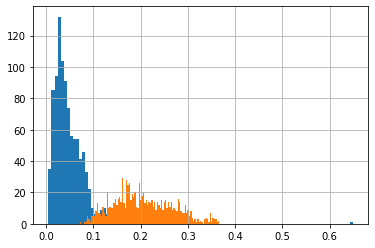

In [46]:
df_model = feature_engineering_pipeline(df,Fengine,func_lists[0])

X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
                                              target="target_COV")

In [47]:
mod = xgb.XGBRegressor(n_estimators=400, learning_rate=0.2,max_depth=1)
mod.fit(X_train,y_train)
r2 = r2_score(y_train,mod.predict(X_train))
print("Training R2: {}".format(r2))
test_r2 = r2_score(y_test,mod.predict(X_test))
print("Test R2: {}".format(test_r2))

[17:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2: 0.7902743041579211
Test R2: 0.5652918671935157


In [52]:
mod = xgb.XGBRegressor(n_estimators=400, learning_rate=0.2,max_depth=1)
mod.fit(X_train,y_train)
r2 = r2_score(y_train,mod.predict(X_train))
print("Training R2: {}".format(r2))
test_r2 = r2_score(y_test,mod.predict(X_test))
print("Test R2: {}".format(test_r2))

[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2: 0.7901624296047034
Test R2: 0.563014509218588


In [80]:
mod = xgb.XGBRegressor(reg_lambda=0.767, reg_alpha=1.639,
                           colsample_bytree=0.507,subsample=0.756,
                           learning_rate=0.576,n_estimators=3787,
                           max_depth=10,min_child_weight=105)
mod.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
r2 = r2_score(y_train,mod.predict(X_train))
print(r2)
test_r2 = r2_score(y_test,mod.predict(X_test))
print(test_r2)

[14:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5439263305774388
0.49204223263469493


In [124]:
r2

0.7277681743786515

In [125]:
scores.mean()

0.6612099423528331

In [126]:
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_test

0.5925540867408895

# Analyze Results

In [151]:
# Fetch project 'jack/sandbox'
project = neptune.get_project(name=neptune_project_name,api_token=get_neptune_key(name))

# Fetch all Runs metadata as Pandas DataFrame
runs_table_df = project.fetch_runs_table().to_pandas()

runs_table_df.columns =  [col.split("/")[2] if "Parameters" in col else col.split("/")[1] for col in runs_table_df.columns]

In [152]:
runs_table_df.sort_values(by='R2_test',ascending=False)[['R2_test','R2_train','owner','Adj_R2_test','Adj_R2_train','MSE_test','MSE_train']].head(50)

,R2_test,R2_train,owner,Adj_R2_test,Adj_R2_train,MSE_test,MSE_train
17,0.77,0.71,harperd17,0.745722,0.702899,0.000177,2.279105e-04
24,0.75,0.85,harperd17,0.723611,0.846327,0.000197,1.154001e-04
18,0.75,0.79,harperd17,0.723611,0.784858,0.000194,1.613202e-04
19,0.73,0.77,harperd17,0.701500,0.764369,0.000213,1.782018e-04
30,0.73,0.73,harperd17,0.701500,0.723389,0.000208,2.049000e-04
25,0.73,0.73,harperd17,0.701500,0.723389,0.000208,2.049000e-04
26,0.73,0.73,harperd17,0.701500,0.723389,0.000208,2.049000e-04
27,0.73,0.73,harperd17,0.701500,0.723389,0.000208,2.049000e-04
136,0.73,0.90,adamgoldsteindatascience,0.698146,0.897287,0.000173,7.689439e-05
150,0.73,0.73,himanshu2512,0.701500,0.723389,0.000208,2.049000e-04


# Lasso

In [116]:
alpha_values = list(np.arange(0,10,0.1))
lasso_train_scores = []
lasso_cv_scores = []
for a in alpha_values:
  lasso_mod = Ridge(a)
  scores = cross_val_score(lasso_mod,X_train,y_train,cv=15)
  lasso_train_scores.append(r2_score(y_train,lasso_mod.fit(X_train,y_train).predict(X_train)))
  lasso_cv_scores.append(scores.mean())

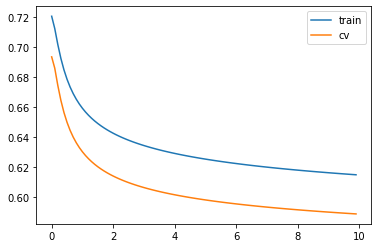

In [117]:
plt.plot(alpha_values,lasso_train_scores,label='train')
plt.plot(alpha_values, lasso_cv_scores,label='cv')
plt.legend();

In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 52.8 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 149 kB 53.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=cd4def43e56c3e5bca0ef3a85078fa3ca1ac2294a78cadac6427e59fe49c2cc0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
param_distributions = {"alpha": optuna.distributions.LogUniformDistribution(1e-10, 1e10)}
optuna_search = optuna.integration.OptunaSearchCV(Lasso(), param_distributions,cv=5, n_trials=100)
optuna_search.fit(X_train, y_train)
#y_train_pred = optuna_search.predict(X_train)

[I 2021-11-24 19:49:51,250] A new study created in memory with name: no-name-479f4ccd-4039-491e-a7b7-cb04ace7fcfa
[I 2021-11-24 19:49:51,294] Trial 0 finished with value: -0.01877294237384599 and parameters: {'alpha': 13.078506301172556}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-24 19:49:51,447] Trial 1 finished with value: 0.5954842684453585 and parameters: {'alpha': 0.00017487800601025995}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:51,471] Trial 2 finished with value: -0.01877294237384599 and parameters: {'alpha': 2369131029.9591446}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:51,516] Trial 3 finished with value: 0.3944687183392594 and parameters: {'alpha': 0.0008205863359182127}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:52,064] Trial 4 finished with value: 0.6719743445461679 and parameters: {'alpha': 8.935067738485735e-10}. Best is trial 4 with value: 0.6719743445461679.
[I 2021-11-24 1

OptunaSearchCV(estimator=Lasso(), n_trials=100,
               param_distributions={'alpha': LogUniformDistribution(high=10000000000.0, low=1e-10)})

In [ ]:
optuna_search.best_params_

{'alpha': 1.6856599148421353e-05}

In [ ]:
optuna_search.best_score_

0.6898058181807643

In [ ]:
r2_score(y_train,y_preds_train)

0.7606056474776971

In [ ]:
r2_score(y_preds_train,y_train)

0.6852582500324439

In [ ]:
import statsmodels.api as sm

In [ ]:
X_train_constant = sm.add_constant(X_train)
mod = sm.OLS(y_train,X_train_constant)
res = mod.fit()

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     28.39
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          7.88e-169
Time:                        19:12:00   Log-Likelihood:                 2244.6
No. Observations:                 776   AIC:                            -4331.
Df Residuals:                     697   BIC:                            -3964.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.498      0.619      -0.002       0.001
x1             0.3337      0.033     10.188      0.000       0.269       0.398
x2            -0.0392      0.029     -1.340      0.181      -0.097       0.018
x3             0.3363      0.187      1.796      0.073      -0.031       0.704
x4          1.351e-06    8.8e-07      1.535      0.125   -3.77e-07    3.08e-06
x5            -0.2969      0.690     -0.430      0.667      -1.651       1.057
x6            -0.3188      0.686     -0.465      0.642      -1.665       1.028
x7            -0.1132      0.715     -0.158      0.874      -1.517       1.291
x8            -0.3187      0.686     -0.465      0.642      -1.666       1.028
x9             0.2421      0.723      0.335      0.738      -1.178       1.662
x10           -0.3097      0.685     -0.452      0.652      -1.655       1.036
x11           -0.3018      0.686     -0.440      0.660      -1.648       1.045
x12           -0.3038      0.686     -0.443      0.658      -1.650       1.042
x13           -0.2569      0.740     -0.347      0.729      -1.709       1.196
x14           -0.2965      0.685     -0.433      0.665      -1.641       1.048
x15           -0.3201      0.686     -0.467      0.641      -1.666       1.026
x16            2.4423      6.956      0.351      0.726     -11.215      16.100
x17           -0.0044      0.004     -1.010      0.313      -0.013       0.004
x18            0.0048      0.002      2.042      0.042       0.000       0.009
x19           -0.0003      0.002     -0.139      0.890      -0.005       0.005
x20           -0.0040      0.001     -3.671      0.000      -0.006      -0.002
x21        -2.942e-06   9.51e-05     -0.031      0.975      -0.000       0.000
x22            0.0001   6.71e-05      1.726      0.085   -1.59e-05       0.000
x23         5.637e-05      0.000      0.513      0.608      -0.000       0.000
x24        -5.689e-05   6.28e-05     -0.906      0.365      -0.000    6.63e-05
x25           -0.0036      0.002     -2.243      0.025      -0.007      -0.000
x26            0.0037      0.002      2.247      0.025       0.000       0.007
x27           -0.0050      0.001     -4.120      0.000      -0.007      -0.003
x28            0.0003      0.001      0.306      0.759      -0.002       0.002
x29            0.0012      0.003      0.378      0.706      -0.005       0.008
x30           -0.0064      0.010     -0.659      0.510      -0.025       0.013
x31            0.0009      0.003      0.252      0.801      -0.006       0.008
x32           -0.0015      0.003     -0.450      0.653      -0.008       0.005
x33            0.0059      0.004      1.332      0.183      -0.003       0.014
x34           -0.0033      0.006     -0.579      0.563      -0.015       0.008
x35           -0.0015      0.007     -0.228      0.820      -0.014       0.011
x3

In [ ]:
from scipy.stats import linregress

In [ ]:
print(y_train.shape)
print(X_train.shape)

(776,)
(776, 99)


In [ ]:
y_train.reshape(-1,1).shape

(776, 1)

In [ ]:
y_train.T.shape

(776,)

In [ ]:
np.concatenate((X_train,y_train.reshape(-1,1)),axis=0)

ValueError: ignored

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(X_train.T, y_train.reshape(-1,1).T)

ValueError: ignored

In [ ]:
r2_score(y_preds_train,y_train)

TypeError: ignored

In [ ]:
y_preds_train = res.predict(sm.add_constant(X_train))
y_preds_test = res.predict(sm.add_constant(X_test))

In [ ]:
RSS_test = ((y_preds_test-y_test)**2).sum()
RTT_test = ((y_test-y_test.mean())**2).sum()
r2_test = 1-RSS_test/RTT_test
print(r2_test)

0.6256468756114006


In [ ]:
np.sqrt(((y_preds_test-y_test)**2).mean())

0.0150377623286495

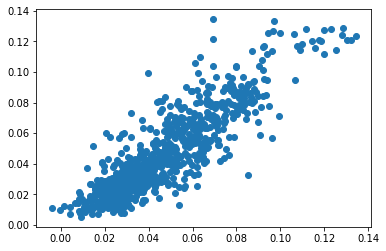

In [ ]:
plt.scatter(y_preds_train,y_train)

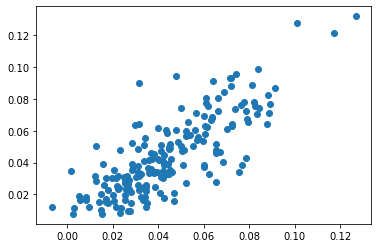

In [ ]:
plt.scatter(y_preds_test,y_test)

In [ ]:
r2_train  = round(r2_score(y_preds_train,y_train),2)
r2_train

0.69

In [ ]:
RSS = ((y_preds_train-y_train)**2).sum()
RTT = ((y_train-y_train.mean())**2).sum()
r2 = 1-RSS/RTT
print(r2)

0.7606056474776973


In [ ]:
N = X.shape[0]
K = X.shape[1]

In [ ]:
adjusted_r2 = 1 - (RSS/(N-K))/(RTT/(N-1))#1-(1-r2)*(N-K-1)/(N-1)
print(adjusted_r2)

0.7336703471939021


In [ ]:
adjusted_r2_train = calc_adjusted_r2(X_train,r2_train)
print(adjusted_r2_train)
#adjusted_r2_test = calc_adjusted_r2(X_test,r2_test)

mse_value_train = mse(y_preds_train,y_train)
print(mse_value_train)

0.6446005917159763
0.0001799326984088624


In [ ]:
np.sqrt(((y_preds_train-y_train)**2).mean())

0.01341389944829103

In [ ]:
|
runs_table_df['creation_time'] = pd.to_datetime(runs_table_df['creation_time'])

In [ ]:
runs_table_df

,creation_time,description,failed,hostname,id,modification_time,monitoring_time,name,owner,ping_time,running_time,size,state,tags,Adj_R2_test,Adj_R2_train,Coef_train,Cust_Columns,Cust_Model,Cust_Pipeline_funcs,Explained_Variance_Score_test,Explained_Variance_Score_train,MSE_test,MSE_train,alpha,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,copy_X,fit_intercept,gamma,importance_type,learning_rate,max_delta_step,max_depth,max_iter,min_child_weight,missing,n_estimators,n_jobs,normalize,nthread,objective,positive,precompute,random_state,reg_alpha,reg_lambda,scale_pos_weight,seed,selection,silent,subsample,tol,verbosity,warm_start,R2_test,R2_train,y_preds_test,y_preds_train,gpu_memory,memory,stdout
0,2021-11-23 22:01:51.718000+00:00,,False,ca2023db8d92,EN-527,2021-11-23 22:01:54.969000+00:00,602,Untitled,adamgoldsteindatascience,2021-11-23 22:01:54.969000+00:00,3.250,17068.0,idle,,-104.094528,-100.005769,[-0.00000000e+00 -0.00000000e+00 -0.00000000e+...,"[['index', 'State', 'Months Above Average Pric...",Lasso,"[[('outlier_thresh', 3), ('col_not_startswith'...",-54.58,-88.19,0.000766,0.000760,1.0,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,deprecated,NaN,NaN,False,False,None,NaN,NaN,NaN,NaN,cyclic,NaN,NaN,0.0001,NaN,False,-54.98,-88.19,[0.04633066 0.04743528 0.0462924 0.04661055 0...,[0.05008786 0.05174153 0.04405032 0.04819989 0...,0.282349,0.448475,"b'Shutting down background jobs, please wait a..."
1,2021-11-23 22:01:47.851000+00:00,,False,ca2023db8d92,EN-526,2021-11-23 22:01:50.998000+00:00,602,Untitled,adamgoldsteindatascience,2021-11-23 22:01:50.998000+00:00,3.147,17012.0,idle,,0.061321,0.490385,[-9.47567719e-05 -2.02089320e-02 7.80579317e-...,"[['index', 'State', 'Months Above Average Pric...",LinearRegression,"[[('outlier_thresh', 3), ('col_not_startswith'...",0.50,0.55,0.000252,0.000241,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,deprecated,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.55,[ 0.02146559 0.01827059 0.03314459 0.041879...,[0.03105055 0.04060757 0.06048119 0.02967938 0...,0.282349,0.448086,"b'Shutting down background jobs, please wait a..."
2,2021-11-23 22:01:45.264000+00:00,,False,ca2023db8d92,EN-525,2021-11-23 22:01:47.159000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:47.159000+00:00,1.894,16136.0,idle,,-2185.897358,-1238.407265,None,"[['index', 'State', 'Months Above Average Pric...",XGBRegressor,"[[('outlier_thresh', 3), ('col_not_startswith'...",-26.05,-24.83,0.026152,0.025613,10.0,0.5,gbtree,1.0,1.0,0.3,NaN,NaN,0.0,gain,0.1,0.0,5.0,NaN,1.0,None,10.0,1,NaN,None,reg:linear,NaN,NaN,0,0.0,1.0,1.0,None,NaN,None,1.0,NaN,1.0,NaN,-1163.88,-1093.42,[0.20172355 0.20172355 0.20485157 0.2031022 0...,[0.20172355 0.20172355 0.21159485 0.20172355 0...,0.282349,0.448509,"b'Shutting down background jobs, please wait a..."
3,2021-11-23 22:01:42.486000+00:00,,False,ca2023db8d92,EN-524,2021-11-23 22:01:44.403000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:44.403000+00:00,1.917,15872.0,idle,,-70.410385,-93.289960,[-0.00000000e+00 -0.00000000e+00 -0.00000000e+...,"[['index', 'State', 'Months Above Average Pric...",Lasso,"[[('outlier_thresh', 3), ('col_not_startswith'...",-54.58,-88.19,0.000766,0.000760,1.0,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,deprecated,NaN,NaN,False,False,None,NaN,NaN,NaN,NaN,cyclic,NaN,NaN,0.0001,NaN,False,-54.98,-88.19,[0.04633066 0.04743528 0.0462924 0.04661055 0...,[0.05008786 0.05174153 0.04405032 0.04819989 0...,0.282349,0.448051,"b'Shutting down background jobs, please wait a..."
4,2021-11-23 22:01:37.923000+00:00,,False,ca2023db8d92,EN-523,2021-11-23 22:01:40.867000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:40.867000+00:00,2.944,15614.0,idle,,0.311154,0.418551,[-9.09149293e-05 -2.08460525e-02 4.09899065e-...,"[['index', 'State', 'Months Above Average Pric...",LinearRegression,"[[('outlier_thresh', 3), ('col

In [ ]:
import plotly.express as px

(px.line(runs_table_df.query('Adj_R2_test > .40').sort_values("creation_time",ascending=False),x="creation_time",y="Adj_R2_test",color="Cust_Model",hover_data=["Adj_R2_test","Adj_R2_test"],
        
        log_y=True,title="Model Performance - Adjusted R2")
        
        .for_each_trace(lambda t: t.update(name=t.name.replace("Cust_Model=","")))
        
        )

In [ ]:
import plotly.express as px

(px.line(runs_table_df.sort_values("creation_time",ascending=False),x="creation_time",y="MSE_test",color="Cust_Model",hover_data=["Adj_R2_test"],
        
        log_y=True,title="Model Performance - MSE")
        
        .for_each_trace(lambda t: t.update(name=t.name.replace("Cust_Model=","")))
        
        )